In [8]:
import pandas as pd
import joblib
from data_process import preprocess, postprocess, inverse_scale_output

data = pd.read_csv('../data/preprocess_data/oneday_weather/data_after_72250_1_val.csv')

data = data[(data['LocationCode_1'] == 1) & (data['Date'] == '2024-05-23')][12:]

print(data.shape)
# save the data
data.to_csv('data_1_power.csv', index=False)

(48, 84)


{'iterations': 10000, 'learning_rate': 0.05, 'depth': 10, 'loss_function': 'RMSE', 'random_seed': 42, 'verbose': 100, 'early_stopping_rounds': 50}
y columns: ['Power_1', 'Power_2', 'Power_3', 'Power_4', 'Power_5', 'Power_6']
X columns: ['Time', 'PS01_466990', 'PS02_466990', 'TX01_466990', 'TD01_466990', 'RH01_466990', 'WD01_466990', 'WD02_466990', 'WD07_466990', 'WD08_466990', 'PP01_466990', 'PP02_466990', 'SS01_466990', 'GR01_466990', 'UV01_466990', 'PS01_72250', 'PS02_72250', 'TX01_72250', 'TD01_72250', 'RH01_72250', 'WD01_72250', 'WD02_72250', 'WD07_72250', 'WD08_72250', 'PP01_72250', 'SS01_72250', 'GR01_72250', 'TS01_72250', 'TS02_72250', 'TS03_72250', 'TS04_72250', 'TS06_72250', 'TS07_72250', 'PS01_466990_date_time_plus_1', 'PS02_466990_date_time_plus_1', 'TX01_466990_date_time_plus_1', 'TD01_466990_date_time_plus_1', 'RH01_466990_date_time_plus_1', 'WD01_466990_date_time_plus_1', 'WD02_466990_date_time_plus_1', 'WD07_466990_date_time_plus_1', 'WD08_466990_date_time_plus_1', 'PP01

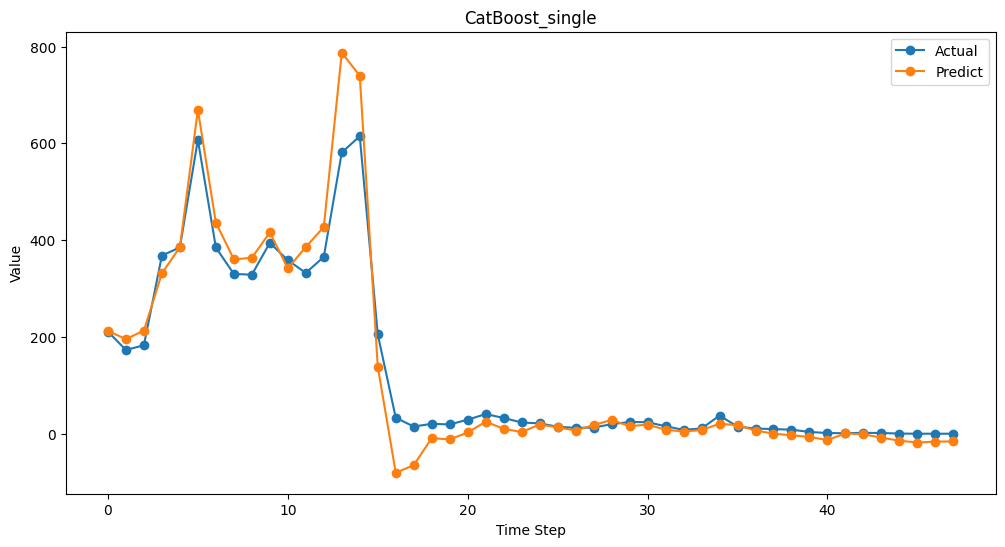

In [30]:
import pandas as pd
import joblib
from data_process import preprocess, postprocess, inverse_scale_output
import numpy as np

model_data = joblib.load("/home/guest/r12922a14/aicup-forecast-power/submit/train_model/catboost_model_single_with_residual.pkl")

models = model_data['models']
residual_models = model_data['models_residual']
print(models[0].get_params())

location_codes = [
"LocationCode_1", "LocationCode_2", "LocationCode_3", "LocationCode_4",
"LocationCode_5", "LocationCode_6", "LocationCode_7", "LocationCode_8",
"LocationCode_9", "LocationCode_10", "LocationCode_11", "LocationCode_12",
"LocationCode_13", "LocationCode_14", "LocationCode_15", "LocationCode_16",
"LocationCode_17"
]

variables = {
    'not_data': ["Date", "Time"] + location_codes,  # for six_timestep
    'y_cols': ["Power"],
    'X_cols': ["^Time$", ".*72250",".*466990$", ".*466990_date_time_plus_1$", ".*466990_date_time_minus_1$", ".*466990_date_minus_1_time$", "nearby", "Lat", "Lon", "Month", "Season", "direction", "floor", "LocationCode"]
}
X_test_scaled, not_data_df = preprocess(
    'data.csv',
    variables,
    172,
    6,
    stage='test'
)

y_list = []
for i, model in enumerate(models):
    y_pred = model.predict(X_test_scaled)
    y_pred_residual = residual_models[i].predict(X_test_scaled)
    y_pred = y_pred + y_pred_residual
    y_list.append(y_pred)

y_pred_scaled = np.array(y_list).T


data = pd.read_csv('/home/guest/r12922a14/aicup-forecast-power/submit/data/preprocess_data/oneday_weather_6timestep/data_after_72250_1_6power_val.csv')
y_true = data[(data['LocationCode_1'] == 1) & (data['Date'] == '2024-05-23')][2:][['Power_1','Power_2','Power_3','Power_4','Power_5','Power_6']]

# plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true.to_numpy().reshape(1, -1).flatten(), label='Actual', marker='o')
plt.plot(y_pred_scaled.flatten(), label='Predict', marker='o')
plt.title('CatBoost_single')  # 設置標題
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

(8, 172)
(8, 6)
[2.11010000e+02 1.73143000e+02 1.82845000e+02 3.68048000e+02
 3.85123000e+02 6.07380000e+02 3.84852000e+02 3.30173000e+02
 3.28638000e+02 3.94475000e+02 3.58525000e+02 3.32390000e+02
 3.65434000e+02 5.81174000e+02 6.14690000e+02 2.05430000e+02
 3.30244444e+01 1.49250000e+01 2.05130000e+01 1.93130000e+01
 2.90340000e+01 4.06930000e+01 3.25955556e+01 2.32590000e+01
 2.14180000e+01 1.45160000e+01 1.21120000e+01 1.28370000e+01
 1.97810000e+01 2.42790000e+01 2.38920000e+01 1.55560000e+01
 8.06800000e+00 1.09260000e+01 3.74660000e+01 1.47970000e+01
 1.07280000e+01 9.67300000e+00 8.40900000e+00 3.72600000e+00
 1.48900000e+00 1.11200000e+00 1.88000000e+00 1.58000000e+00
 3.53000000e-01 1.18000000e-01 6.10000000e-02 1.17000000e-01]


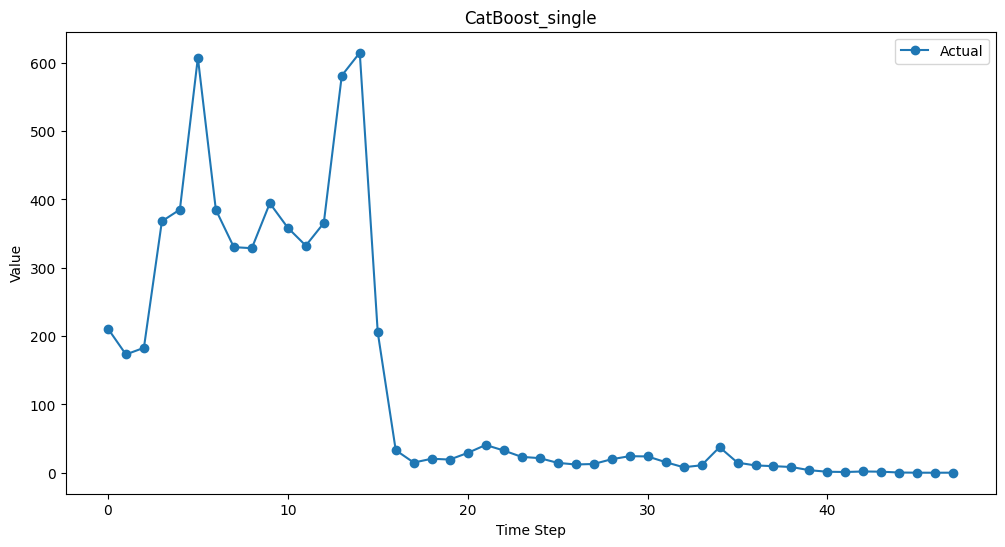

In [ ]:
import pandas as pd

data = pd.read_csv('/home/guest/r12922a14/aicup-forecast-power/submit/data/preprocess_data/oneday_weather_6timestep/data_after_72250_1_6power_val.csv')

# find location code = 1 and Date_Day1=2024-05-22
col = ["^Time$", ".*72250",".*466990$", ".*466990_date_time_plus_1$", ".*466990_date_time_minus_1$", ".*466990_date_minus_1_time$", "nearby", "Lat", "Lon", "Month", "Season", "direction", "floor", "LocationCode"]
regex_pattern = "|".join(col)
X = data[(data['LocationCode_1'] == 1) & (data['Date'] == '2024-05-23')].filter(regex=regex_pattern)[2:]
# TimeMinGroup
print(X.to_numpy().shape)

y_true = data[(data['LocationCode_1'] == 1) & (data['Date'] == '2024-05-23')][2:][['Power_1','Power_2','Power_3','Power_4','Power_5','Power_6']]
print(y_true.to_numpy().shape)
print(y_true.to_numpy().reshape(1, -1).flatten())
# plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true.to_numpy().reshape(1, -1).flatten(), label='Actual', marker='o')
plt.title('CatBoost_single')  # 設置標題
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 讀取數據
data_path = '../data/preprocess_data/oneday_weather/data_after_72250_1.csv'
data_for_train_test_split = pd.read_csv(data_path)

# 提取 target
target = data_for_train_test_split[(data_for_train_test_split['LocationCode_1'] == 1) & (data_for_train_test_split['Date'] == '2024-05-23')]
print(target)

# 移除 target 後的數據
remaining_data = data_for_train_test_split.drop(target.index)

# 對剩餘數據進行 train_test_split
train, test = train_test_split(remaining_data, test_size=0.2, random_state=42)

# 將 target 加回 test set
test = pd.concat([test, target], ignore_index=True)

# 檢查結果
print(f"Training set size: {train.shape}")
print(f"Test set size: {test.shape}")
print(f"Target added to test set: {target.shape}")

train.to_csv(data_path.replace('.csv', '_train.csv'), index=False)
test.to_csv(data_path.replace('.csv', '_val.csv'), index=False)


            Date TimeMinGroup  Pressure(hpa)  Temperature(°C)  Humidity(%)  \
5579  2024-05-23        07:00    1004.637000        27.470000   100.000000   
5580  2024-05-23        07:10    1004.724000        28.630000   100.000000   
5581  2024-05-23        07:20    1004.789000        29.630000   100.000000   
5582  2024-05-23        07:30    1004.807000        30.720000   100.000000   
5583  2024-05-23        07:40    1004.845556        32.133333   100.000000   
5584  2024-05-23        07:50    1004.784000        34.030000   100.000000   
5585  2024-05-23        08:00    1004.742000        34.730000   100.000000   
5586  2024-05-23        08:10    1004.730000        38.920000   100.000000   
5587  2024-05-23        08:20    1004.785000        43.010000    80.250000   
5588  2024-05-23        08:30    1004.788000        44.160000    66.410000   
5589  2024-05-23        08:40    1004.849000        45.850000    52.870000   
5590  2024-05-23        08:50    1004.916000        42.850000   

In [1]:
import joblib

# 讀取已儲存的模型
loaded_data = joblib.load('catboost_model_next_hour.pkl')

# 提取模型
cat_models_loaded = loaded_data['models']

# 確認讀取成功
print(f"Loaded {len(cat_models_loaded)} models.")


from data_process import preprocess, postprocess, inverse_scale_output

train_data_path = 'Data/six_timestep/data_after_72250_1_6power_nexthour_train.csv'
val_data_path = 'Data/six_timestep/data_after_72250_1_6power_nexthour_val.csv'

variables = {
    # 'not_data': ["Date", "TimeMinGroup", "yyyymmddhh"],
    'not_data': ["Date"],  # for six_timestep
    'y_cols': ["Power"],
    'X_cols': ["LocationCode", "Lat", "Lon", "Month", "direction", "floor", "^Time$", "Season", "466990", "72250", "nearby"]
}

expected_X_columns=108
expected_y_columns=6

X_train_scaled, y_train_scaled, X_scaler, y_scaler = preprocess(
    train_data_path,
    variables,
    expected_X_columns,
    expected_y_columns,
    stage='train',
    y_scaled=False
)

train_scaler = {
    'X': X_scaler,
    'y': y_scaler
}

X_test_scaled, y_test_scaled, y_test = preprocess(
    val_data_path,
    variables,
    expected_X_columns,
    expected_y_columns,
    stage='val',
    train_scaler=train_scaler,
    y_scaled=False
)


Loaded 6 models.
y columns: ['Power_1', 'Power_2', 'Power_3', 'Power_4', 'Power_5', 'Power_6']
X columns: ['Time', 'PS01_466990_x', 'PS02_466990_x', 'TX01_466990_x', 'TD01_466990_x', 'RH01_466990_x', 'WD01_466990_x', 'WD02_466990_x', 'WD07_466990_x', 'WD08_466990_x', 'PP01_466990_x', 'PP02_466990_x', 'SS01_466990_x', 'GR01_466990_x', 'UV01_466990_x', 'PS01_72250_x', 'PS02_72250_x', 'TX01_72250_x', 'TD01_72250_x', 'RH01_72250_x', 'WD01_72250_x', 'WD02_72250_x', 'WD07_72250_x', 'WD08_72250_x', 'PP01_72250_x', 'SS01_72250_x', 'GR01_72250_x', 'TS01_72250_x', 'TS02_72250_x', 'TS03_72250_x', 'TS04_72250_x', 'TS06_72250_x', 'TS07_72250_x', 'PS01_466990_y', 'PS02_466990_y', 'TX01_466990_y', 'TD01_466990_y', 'RH01_466990_y', 'WD01_466990_y', 'WD02_466990_y', 'WD07_466990_y', 'WD08_466990_y', 'PP01_466990_y', 'PP02_466990_y', 'SS01_466990_y', 'GR01_466990_y', 'UV01_466990_y', 'PS01_72250_y', 'PS02_72250_y', 'TX01_72250_y', 'TD01_72250_y', 'RH01_72250_y', 'WD01_72250_y', 'WD02_72250_y', 'WD07_722

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

test_mse_list = []
test_r2_list = []
test_y_list = []
for i, target in enumerate(['Power_1', 'Power_2', 'Power_3', 'Power_4', 'Power_5', 'Power_6']):
  test_y_pred_cat = cat_models_loaded[i].predict(X_test_scaled)
  test_mse = mean_squared_error(y_test_scaled[:, i], test_y_pred_cat)

  # rmse = mse ** 0.5
  test_r2 = r2_score(y_test_scaled[:, i], test_y_pred_cat)

  test_mse_list.append(test_mse)
  test_r2_list.append(test_r2)
  test_y_list.append(test_y_pred_cat)

test_y_list = np.array(test_y_list).T

print(np.mean(test_mse_list))

train_mse_list = []
train_r2_list = []
train_y_list = []
for i, target in enumerate(['Power_1', 'Power_2', 'Power_3', 'Power_4', 'Power_5', 'Power_6']):
  train_y_pred_cat = cat_models_loaded[i].predict(X_train_scaled)
  train_mse = mean_squared_error(y_train_scaled[:, i], train_y_pred_cat)

  # rmse = mse ** 0.5
  train_r2 = r2_score(y_train_scaled[:, i], train_y_pred_cat)

  train_mse_list.append(train_mse)
  train_r2_list.append(train_r2)
  train_y_list.append(train_y_pred_cat)

train_y_list = np.array(train_y_list).T

print(np.mean(train_mse_list))



26057.365700685692
166.88903703883292


Matplotlib created a temporary cache directory at /tmp/matplotlib-9a6n_062 because the default path (/home/guest/r12922a14/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


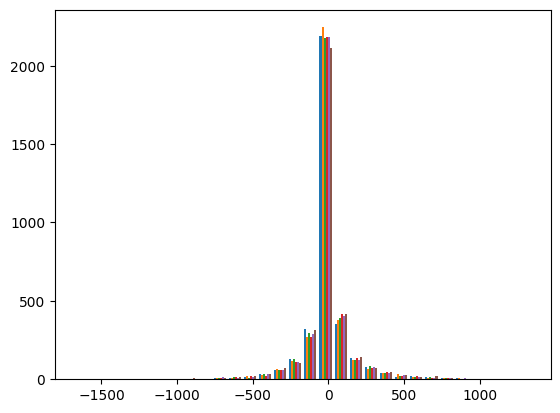

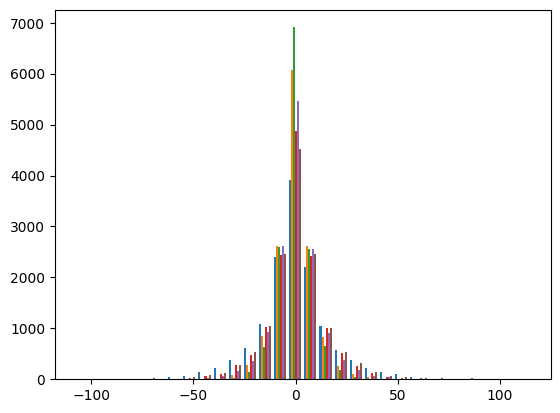

In [3]:
import matplotlib.pyplot as plt

# 計算殘差並展平為一維數組
test_residual = (y_test_scaled - test_y_list)
train_residual = (y_train_scaled - train_y_list)

# 繪製直方圖
plt.hist(test_residual, bins=30)
plt.show()

plt.hist(train_residual, bins=30)
plt.show()

(20634,)
(82512, 1)


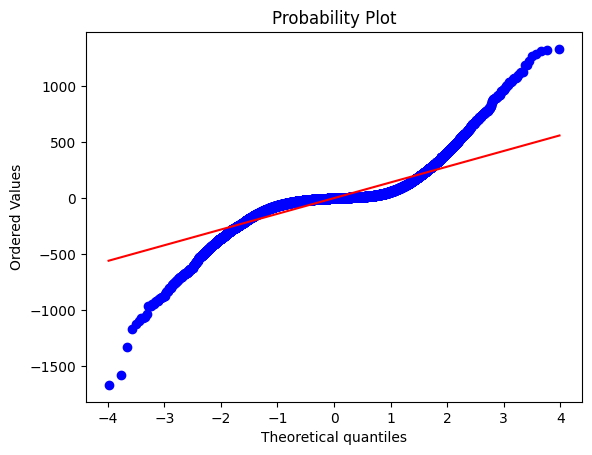

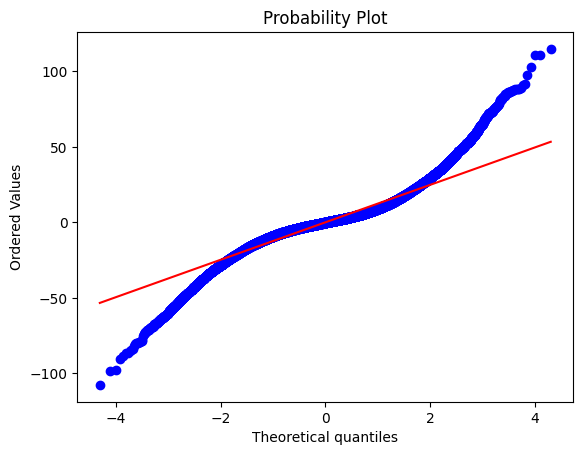

Shapiro-Wilk Test statistic: 0.7555709313816728, p-value: 1.8506350778091812e-98
Shapiro-Wilk Test statistic: 0.9198793876359379, p-value: 3.2442176163632643e-102


/home/guest/r12922a14/anaconda3/envs/power/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20634.
  res = hypotest_fun_out(*samples, **kwds)
/home/guest/r12922a14/anaconda3/envs/power/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 82512.
  res = hypotest_fun_out(*samples, **kwds)


In [4]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy import stats

# 假設 residual 是你的數據
print(test_residual.reshape(-1,1).flatten().shape)
print(train_residual.reshape(-1,1).shape)

stats.probplot(test_residual.reshape(-1,1).flatten(), dist="norm", plot=plt)
plt.show()

stats.probplot(train_residual.reshape(-1,1).flatten(), dist="norm", plot=plt)
plt.show()


stat, p_value = stats.shapiro(test_residual)
print(f"Shapiro-Wilk Test statistic: {stat}, p-value: {p_value}")

stat, p_value = stats.shapiro(train_residual)
print(f"Shapiro-Wilk Test statistic: {stat}, p-value: {p_value}")


/tmp/ipykernel_408815/3265047546.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_408815/3265047546.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


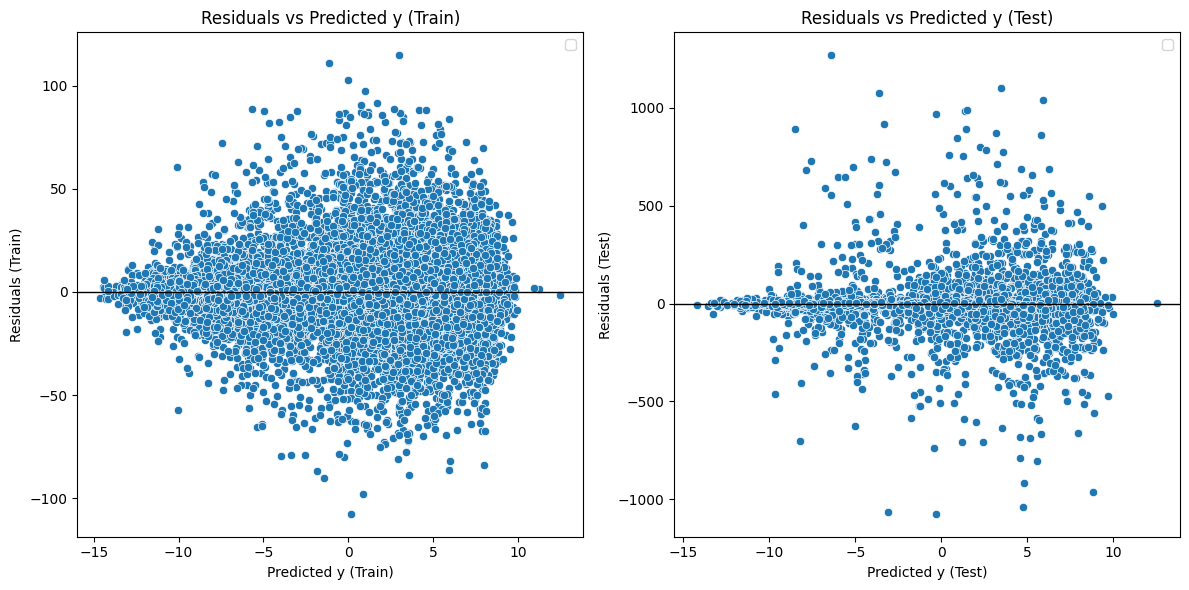

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_test = X_test_scaled
X_train = X_train_scaled

# 假設 X 是你的特徵矩陣，並且 residual 是你的殘差
pca = PCA(n_components=2)
X_test_PCA = pca.fit_transform(X_test)  # 降維到2維
X_train_PCA = pca.fit_transform(X_train)  # 降維到2維

# # 假設 X 是特徵矩陣，residual 是殘差
# tsne = TSNE(n_components=2)
# X_tsne = tsne.fit_transform(X)  # 將數據降維到2維

plt.figure(figsize=(12, 6))

# sns.scatterplot(x=X_train[:, 0], y=train_residual[:, 0])  # 只繪製第一個特徵 (X_1)
# plt.xlabel('X_1')
# plt.ylabel('Residuals')
# plt.title('Train Residuals vs X_1')
# plt.axhline(0, color='black',linewidth=1)  # 基準線
# plt.show()

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_train_PCA[:, 0], y=train_residual[:, 0])  # 只繪製第一個特徵 (X_1)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Predicted y (Train)')
plt.ylabel('Residuals (Train)')
plt.title('Residuals vs Predicted y (Train)')
plt.legend()

# sns.scatterplot(x=X_test[:, 0], y=test_residual[:, 0])  # 只繪製第一個特徵 (X_1)
# plt.xlabel('X_1')
# plt.ylabel('Residuals')
# plt.title('Test Residuals vs X_1')
# plt.axhline(0, color='black',linewidth=1)  # 基準線
# plt.show()

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_test_PCA[:, 0], y=test_residual[:, 0])  # 只繪製第一個特徵 (X_1)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Predicted y (Test)')
plt.ylabel('Residuals (Test)')
plt.title('Residuals vs Predicted y (Test)')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
from scipy import stats

# 假設 train_residuals 和 test_residuals 是你計算出來的殘差
for i in range(6):
    print("ks")
    ks_statistic, p_value = stats.ks_2samp(train_residual[:, i], test_residual[:, i])

    print(f"KS statistic: {ks_statistic}")
    print(f"P-value: {p_value}")

    # 根據 p-value 來做判斷
    alpha = 0.05  # 顯著性水平
    if p_value < alpha:
        print("拒絕虛無假設：兩個分佈顯著不同")
    else:
        print("無法拒絕虛無假設：兩個分佈沒有顯著不同")

    print("t")
    # 假設 train_residuals 和 test_residuals 是你計算出來的殘差
    t_statistic, p_value = stats.ttest_ind(train_residual[:, i], test_residual[:, i])

    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")

    # 根據 p-value 來做判斷
    alpha = 0.05  # 顯著性水平
    if p_value < alpha:
        print("拒絕虛無假設：兩組均值顯著不同")
    else:
        print("無法拒絕虛無假設：兩組均值沒有顯著不同")



ks
KS statistic: 0.21741181932394066
P-value: 1.2109190844480911e-114
拒絕虛無假設：兩個分佈顯著不同
t
T-statistic: 0.8667461890470215
P-value: 0.3860931902338737
無法拒絕虛無假設：兩組均值沒有顯著不同
ks
KS statistic: 0.2941057736760402
P-value: 2.37992354164108e-211
拒絕虛無假設：兩個分佈顯著不同
t
T-statistic: 1.5652674657149919
P-value: 0.11753861668420854
無法拒絕虛無假設：兩組均值沒有顯著不同
ks
KS statistic: 0.3231199044393934
P-value: 4.087598598149949e-256
拒絕虛無假設：兩個分佈顯著不同
t
T-statistic: 1.5698669135932126
P-value: 0.11646448290562282
無法拒絕虛無假設：兩組均值沒有顯著不同
ks
KS statistic: 0.24017231425250618
P-value: 3.855423560345496e-140
拒絕虛無假設：兩個分佈顯著不同
t
T-statistic: -1.5439558769466564
P-value: 0.1226174310221804
無法拒絕虛無假設：兩組均值沒有顯著不同
ks
KS statistic: 0.2670654814796771
P-value: 9.979063240773258e-174
拒絕虛無假設：兩個分佈顯著不同
t
T-statistic: 0.02810188310126351
P-value: 0.9775812184071422
無法拒絕虛無假設：兩組均值沒有顯著不同
ks
KS statistic: 0.2456216683320249
P-value: 1.2166573066933154e-146
拒絕虛無假設：兩個分佈顯著不同
t
T-statistic: 1.4248909021761904
P-value: 0.15420689572810473
無法拒絕虛無假設：兩組均值沒有顯

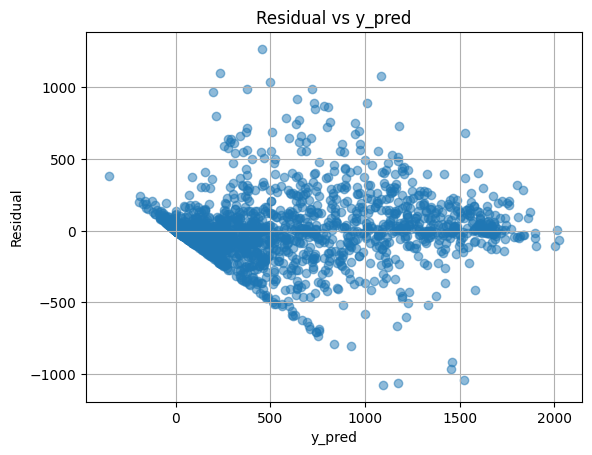

In [22]:
import matplotlib.pyplot as plt

# 繪製散點圖
idx = 0

plt.scatter(y_list[:, idx], residual[:, idx], alpha=0.5)
plt.title('Residual vs y_pred')
plt.xlabel('y_pred')
plt.ylabel('Residual')
plt.grid(True)
plt.show()


In [2]:
import pandas as pd
data = pd.read_csv('/home/guest/r12922a14/aicup-forecast-power/Data/new_data/data_after_1_6power_nextfronthour.csv')

print(data.columns.to_list())

['Date', 'Time', 'Power_1', 'Power_2', 'Power_3', 'Power_4', 'Power_5', 'Power_6', 'yyyymmddhh', 'PS01_466990', 'PS02_466990', 'TX01_466990', 'TD01_466990', 'RH01_466990', 'WD01_466990', 'WD02_466990', 'WD07_466990', 'WD08_466990', 'PP01_466990', 'PP02_466990', 'SS01_466990', 'GR01_466990', 'UV01_466990', 'PS01_72250', 'PS02_72250', 'TX01_72250', 'TD01_72250', 'RH01_72250', 'WD01_72250', 'WD02_72250', 'WD07_72250', 'WD08_72250', 'PP01_72250', 'SS01_72250', 'GR01_72250', 'TS01_72250', 'TS02_72250', 'TS03_72250', 'TS04_72250', 'TS06_72250', 'TS07_72250', 'Time_plus_1', 'Time_minus_1', 'Date_minus_1', 'yyyymmddhh_date_time_plus_1', 'PS01_466990_date_time_plus_1', 'PS02_466990_date_time_plus_1', 'TX01_466990_date_time_plus_1', 'TD01_466990_date_time_plus_1', 'RH01_466990_date_time_plus_1', 'WD01_466990_date_time_plus_1', 'WD02_466990_date_time_plus_1', 'WD07_466990_date_time_plus_1', 'WD08_466990_date_time_plus_1', 'PP01_466990_date_time_plus_1', 'PP02_466990_date_time_plus_1', 'SS01_46699

In [3]:
a=['LocationCode_1', 'LocationCode_2', 'LocationCode_3', 'LocationCode_4', 'LocationCode_5', 'LocationCode_6', 'LocationCode_7', 'LocationCode_8', 'LocationCode_9', 'LocationCode_10', 'LocationCode_11', 'LocationCode_12', 'LocationCode_13', 'LocationCode_14', 'LocationCode_15', 'LocationCode_16', 'LocationCode_17','Time'
                , 'PS01_466990', 'PS02_466990', 'TX01_466990', 'TD01_466990', 'RH01_466990', 'WD01_466990', 'WD02_466990', 'WD07_466990', 'WD08_466990', 'PP01_466990', 'PP02_466990', 'SS01_466990', 'GR01_466990', 'UV01_466990'
                , 'PS01_466990_date_time_plus_1', 'PS02_466990_date_time_plus_1', 'TX01_466990_date_time_plus_1', 'TD01_466990_date_time_plus_1', 'RH01_466990_date_time_plus_1', 'WD01_466990_date_time_plus_1', 'WD02_466990_date_time_plus_1', 'WD07_466990_date_time_plus_1', 'WD08_466990_date_time_plus_1', 'PP01_466990_date_time_plus_1', 'PP02_466990_date_time_plus_1', 'SS01_466990_date_time_plus_1', 'GR01_466990_date_time_plus_1', 'UV01_466990_date_time_plus_1'
                , 'PS01_466990_date_minus_1_time', 'PS02_466990_date_minus_1_time', 'TX01_466990_date_minus_1_time', 'TD01_466990_date_minus_1_time', 'RH01_466990_date_minus_1_time', 'WD01_466990_date_minus_1_time', 'WD02_466990_date_minus_1_time', 'WD07_466990_date_minus_1_time', 'WD08_466990_date_minus_1_time', 'PP01_466990_date_minus_1_time', 'PP02_466990_date_minus_1_time', 'SS01_466990_date_minus_1_time', 'GR01_466990_date_minus_1_time', 'UV01_466990_date_minus_1_time'
                 , 'nearby'
                 , 'Lat', 'Lon'
                 , 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10'
                 , 'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter'
                 , 'direction_南', 'direction_東', 'direction_東南', 'direction_西', 'direction_西北', 'direction_西南'
                 , 'floor_1', 'floor_3', 'floor_5'
]

print(len(a))

86


In [4]:
e = []
for i in data.columns:
    if i not in a:
        print(i)
        e.append(i)

Date
Power_1
Power_2
Power_3
Power_4
Power_5
Power_6
yyyymmddhh
PS01_72250
PS02_72250
TX01_72250
TD01_72250
RH01_72250
WD01_72250
WD02_72250
WD07_72250
WD08_72250
PP01_72250
SS01_72250
GR01_72250
TS01_72250
TS02_72250
TS03_72250
TS04_72250
TS06_72250
TS07_72250
Time_plus_1
Time_minus_1
Date_minus_1
yyyymmddhh_date_time_plus_1
Time_date_time_plus_1
PS01_72250_date_time_plus_1
PS02_72250_date_time_plus_1
TX01_72250_date_time_plus_1
TD01_72250_date_time_plus_1
RH01_72250_date_time_plus_1
WD01_72250_date_time_plus_1
WD02_72250_date_time_plus_1
WD07_72250_date_time_plus_1
WD08_72250_date_time_plus_1
PP01_72250_date_time_plus_1
SS01_72250_date_time_plus_1
GR01_72250_date_time_plus_1
TS01_72250_date_time_plus_1
TS02_72250_date_time_plus_1
TS03_72250_date_time_plus_1
TS04_72250_date_time_plus_1
TS06_72250_date_time_plus_1
TS07_72250_date_time_plus_1
yyyymmddhh_date_time_minus_1
PS01_466990_date_time_minus_1
PS02_466990_date_time_minus_1
TX01_466990_date_time_minus_1
TD01_466990_date_time_minus

In [7]:
import pandas as pd

# 讀取兩個資料集
data1 = pd.read_csv('/home/guest/r12922a14/aicup-forecast-power/Data/new_data/data_after_test_1_6power_nextfronthour.csv')
data2 = pd.read_csv('/home/guest/r12922a14/aicup-forecast-power/Data/result/result_72250.csv')

# 假設 index 已對應，直接進行 join
data2 = data2.join(data1[['Time']])

# 顯示合併後的資料
print(data2)

data2.to_csv('/home/guest/r12922a14/aicup-forecast-power/Data/result/result_72250_time.csv', index=False)

            Date  LocationCode_1  LocationCode_2  LocationCode_3  \
0     2024-01-06               1               0               0   
1     2024-01-06               1               0               0   
2     2024-01-06               1               0               0   
3     2024-01-06               1               0               0   
4     2024-01-06               1               0               0   
...          ...             ...             ...             ...   
2776  2024-07-09               0               0               0   
2777  2024-07-09               0               0               0   
2778  2024-07-09               0               0               0   
2779  2024-07-09               0               0               0   
2780  2024-07-12               0               0               0   

      LocationCode_4  LocationCode_5  LocationCode_6  LocationCode_7  \
0                  0               0               0               0   
1                  0               0   

In [5]:
X_cols = ["LocationCode", "^Time$","Lat", ".*466990$", ".*466990_date_time_plus_1$", ".*466990_date_minus_1_time$", "Lon", "Month", "direction", "floor",  "Season", "nearby"]
regex_pattern = "|".join(X_cols)
X_df = data.filter(regex=regex_pattern)

for i in e:
    if i in X_df.columns:
        print(i)

In [9]:
import pandas as pd

# 讀取原始數據
data = pd.read_csv('/home/guest/r12922a14/aicup-forecast-power/result.csv')

import pandas as pd

# 讀取原始資料
data = pd.read_csv('/home/guest/r12922a14/aicup-forecast-power/result.csv')

# 創建一個新的序號欄位
# 先將 Date 和 Time 合併並格式化
data['序號'] = data['Date'].astype(str) + data['Time'].astype(str).str.zfill(2) + '0001'

# 將每個 Power 欄位轉換為新的答案行
power_columns = ['Power_1', 'Power_2', 'Power_3', 'Power_4', 'Power_5', 'Power_6']
result = data.melt(id_vars=['序號'], value_vars=power_columns, var_name='Power Type', value_name='答案')

# 顯示轉換後的結果
print(result[['序號', '答案']])

# 將結果寫入新的 CSV 文件
result[['序號', '答案']].to_csv('/home/guest/r12922a14/aicup-forecast-power/result123456.csv', index=False)



                     序號           答案
0      2024-01-06090001  1091.795737
1      2024-01-06100001  1755.015798
2      2024-01-06110001  1540.029397
3      2024-01-06120001  1320.620309
4      2024-01-06130001  1052.139883
...                 ...          ...
16801  2024-07-09130001   656.624894
16802  2024-07-09140001   125.976060
16803  2024-07-09150001    20.267736
16804  2024-07-09160001    71.708394
16805  2024-07-12160001    30.503403

[16806 rows x 2 columns]
